# 3.2 청년세대 지니계수 추이

- [1 필요 함수](#1-필요-함수)
- [2 데이터](#2-데이터)
- [3 순자산](#3-순자산)
- [4 가구소득](#4-가구소득)
- [5 처분가능소득](#5-처분가능소득)

## 1 필요 함수

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.stats import moment

def weighted_mean(x, weights):
    return np.sum(x * weights) / np.sum(weights)

def weighted_moment(data, weights, order):
    mean = weighted_mean(data, weights)
    return np.sum(weights * (data - mean) ** order) / np.sum(weights)

def weighted_std(data, weights):
    mean = weighted_mean(data, weights)
    variance = np.sum(weights * ((data - mean) ** 2)) / np.sum(weights)
    return np.sqrt(variance)

def weighted_skewness(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m3 = weighted_moment(data, weights, 3)
    skewness = (np.sqrt(np.sum(weights)) * m3) / (m2 ** 1.5)
    return skewness

def weighted_kurtosis(data, weights):
    m2 = weighted_moment(data, weights, 2)
    m4 = weighted_moment(data, weights, 4)
    kurtosis = (np.sum(weights) * m4) / (m2 ** 2)
    return kurtosis

In [3]:
import numpy as np

def weighted_gini(x, w):
    # 데이터를 값 순서대로 정렬
    sorted_data = np.asarray([x, w]).T[np.argsort(x)]  # x 기준 오름차순으로 정렬
    sorted_x, sorted_w = sorted_data[:, 0], sorted_data[:, 1]
    
    # 총 가중치 및 누적 가중치 초기화
    total_weight = np.sum(sorted_w)
    sorted_w = sorted_w/total_weight
    cumulative_weight = np.cumsum(sorted_w)
     
    # 지니 계수 계산 항목
    sorted_x_dev = sorted_x - weighted_mean(sorted_x, sorted_w)
    
    f_hat = cumulative_weight.copy()    
    # f_hat 업데이트
    for i in range(len(f_hat)):
        if i == 0:            
            f_hat[i] = sorted_w[i] / 2
        else:
            f_hat[i] = cumulative_weight[i-1] + (sorted_w[i] / 2)

    f_hat_dev = f_hat - f_hat.mean()
    G = sorted_w*sorted_x_dev*f_hat_dev/(weighted_mean(sorted_x, sorted_w))
    weighted_gini = 2*G.sum()
   
    return weighted_gini 

## 2 데이터

- 한국: **가계금융복지조사**(Survey of Household Finances and Living Conditions) 
   - [2022년 조사결과](https://kostat.go.kr/board.es?mid=a10301040300&bid=215&act=view&list_no=422053), [통계설명자료](https://www.narastat.kr/metasvc/svc/SvcMetaDcDtaPopup.do?confmNo=930001), [마이크로데이터](https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240)

- 미국: [Survey of Consumer Finances (SCF)](https://www.federalreserve.gov/econres/scfindex.htm)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.optimize as opt
import scipy.stats as st
import matplotlib.pyplot as plt

#### 데이터 다운로딩

>원시(raw) 데이터는 <a href="https://mdis.kostat.go.kr/dwnlSvc/ofrSurvSearch.do?curMenuNo=UI_POR_P9240">MDIS</a>(MicroData Integrated Service)에서 "소득·소비·자산 > 가계금융조사"를 선택해 필요한 연도의 조사 자료를 다운로드 받는다. 
>
>다음 명령문은 다운로드 받은 2010년부터 2023년까지의 CSV 파일을 불러들이는 작업이다. 

In [5]:
# 파일 경로와 이름의 패턴 설정
file_pattern = "../Data/SHF/{year}.csv"

# 데이터를 저장할 변수 초기화
dfs = []

# 2010부터 2023까지의 파일 로드
for year in range(2010, 2024):
    file_name = file_pattern.format(year=year)
    df_name = "df_{year}".format(year=year)
    df = pd.read_csv(file_name, encoding='EUC-KR')
    dfs.append((df_name, df))

# 결과를 변수에 저장
for df_name, df in dfs:
    globals()[df_name] = df

In [6]:
df_2023

,조사연도,MD제공용_가구고유번호,가중값,수도권여부,가구주_성별코드,가구원수,노인가구여부,조손가구여부,한부모가구여부,다문화가구여부(2012년~),...,원리금상환_가계지출감소항목코드,부채상환가능시기코드,가구주_은퇴여부,가구주_미은퇴_은퇴연령,가구주_미은퇴_최소생활비,가구주_미은퇴_적정생활비,가구주_미은퇴_노후준비상황코드,가구주_은퇴_은퇴연령,가구주_은퇴_적정생활비충당여부,가구주은퇴_생활비재원마련코드(2014년~)
0,2023,10000162,1077.906572,G1,2,1,G1,G2,G2,G2,...,NaN,NaN,1,77.0,100,200,5.0,NaN,NaN,NaN
1,2023,10000182,1086.438541,G1,1,2,G2,G2,G2,G2,...,NaN,NaN,1,70.0,200,200,3.0,NaN,NaN,NaN
2,2023,10000192,3626.894382,G1,2,1,G2,G2,G2,G2,...,NaN,NaN,1,70.0,300,400,5.0,NaN,NaN,NaN
3,2023,10000212,758.167174,G2,2,1,G1,G2,G2,G2,...,NaN,NaN,1,75.0,150,200,3.0,NaN,NaN,NaN
4,2023,10000222,1404.353475,G2,1,1,G2,G2,G2,G2,...,NaN,2.0,1,65.0,200,200,3.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18089,2023,991300362,545.333267,G2,1,3,G2,G2,G2,G2,...,NaN,NaN,1,65.0,100,150,5.0,NaN,NaN,NaN
18090,2023,991900211,465.444170,G2,1,4,G2,G2,G2,G2,...,NaN,NaN,1,65.0,200,300,3.0,NaN,NaN,NaN
18091,2023,991900221,648.366811,G2,1,3,G2,G2,G2,G2,...,1.0,1.0,1,60.0,300,500,3.0,NaN,NaN,NaN
18092,2023,991900301,628.892098,G2,1,4,G2,G2,G2,G2,...,NaN,NaN,1,62.0,300,600,2.0,NaN,NaN,NaN


## 3 순자산

In [7]:
import pandas as pd

# 연도 지정
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', 
         '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# 결과를 저장할 딕셔너리 초기화
networth_dict = {}
age_dict = {}
weight_dict = {}

# 각 연도별로 파일 읽기 및 데이터 추출
for year in years:
    # 해당 연도에 대한 df 지정
    data = globals()[f'df_{year}']
    
    # 순자산, 가구주_만연령, 가중값 추출 및 저장
    networth_dict[f'networth_{year}'] = data['순자산'] / 100 # 백만 원
    age_dict[f'age_{year}'] = data['가구주_만연령']
    weight_dict[f'weight_{year}'] = data['가중값']

In [8]:
# 연령대 정의
age_ranges = {'전체': (0, 200), '2030': (0, 39), '청년': (0, 34)}

# df_stats_age 초기화 (패널 데이터 형식)
index = pd.MultiIndex.from_product([years, age_ranges.keys()], 
                                   names=['year', 'age_range'])
df_stats_age = pd.DataFrame(index=index, columns=['mean', 'std', 'gini'])

# 각 연도 및 연령대별로 계산
for year in years:
    x1 = networth_dict[f'networth_{year}']
    x2 = age_dict[f'age_{year}']
    weight = weight_dict[f'weight_{year}']
    w = weight / weight.sum()
    
    for age_range, (age_min, age_max) in age_ranges.items():
        mask = (x2 >= age_min) & (x2 <= age_max)
        x1_filtered = x1[mask]
        w_filtered = w[mask]
        
        mean = weighted_mean(x1_filtered, w_filtered)
        std = weighted_std(x1_filtered, w_filtered)
        gini = weighted_gini(x1_filtered, w_filtered)
        
        df_stats_age.loc[(year, age_range), 'mean'] = mean
        df_stats_age.loc[(year, age_range), 'std'] = std
        df_stats_age.loc[(year, age_range), 'gini'] = gini

print("연도/연령대별 순자산 통계량")
print(df_stats_age)

연도/연령대별 순자산 통계량
                      mean         std      gini
year age_range                                  
2010 전체         230.657574  477.260124  0.643432
     2030       138.121877  208.577683   0.58305
     청년          102.62714  155.319866  0.582989
2011 전체         245.600517  486.435337   0.63248
     2030       142.660868  208.387948  0.572788
     청년         107.025943   175.02523  0.594976
2012 전체         268.747221  496.917984  0.624853
     2030       165.703763  214.453961  0.544956
     청년          126.53076  157.024707  0.537656
2013 전체         268.305843  485.620848  0.612701
     2030       160.954082  200.140663  0.525907
     청년         121.322938  134.031385  0.519798
2014 전체          274.88073  473.921152  0.598822
     2030       166.795092   185.30722  0.509188
     청년         126.564644  135.800865  0.504588
2015 전체         284.291525  472.253402  0.595184
     2030       177.571498  228.411257  0.515971
     청년         137.939052  227.898565  0.526167
2016

In [9]:
# gini 값만 추출하여 재구조화
df_gini_age = df_stats_age['gini'].unstack(level='age_range')
df_gini_age = df_gini_age[['전체', '2030', '청년']]

print("연도/연령대별 순자산 지니계수")
print(df_gini_age)

연도/연령대별 순자산 지니계수
age_range        전체      2030        청년
year                                   
2010       0.643432   0.58305  0.582989
2011        0.63248  0.572788  0.594976
2012       0.624853  0.544956  0.537656
2013       0.612701  0.525907  0.519798
2014       0.598822  0.509188  0.504588
2015       0.595184  0.515971  0.526167
2016       0.591519  0.519521  0.553714
2017       0.588894  0.537534  0.569255
2018       0.593258  0.552074  0.576715
2019       0.602468  0.554623  0.580352
2020       0.608496   0.56659  0.586831
2021       0.607872  0.570448   0.59536
2022       0.609923   0.59698  0.626157
2023       0.609317  0.581932  0.576667


**그래프 한글 표시**

* 그래프에서 한글이 깨지는 것을 막기 위해서는 아래 명령문을 실행해야 한다.

In [10]:
import matplotlib
from matplotlib import font_manager, rc

font_path = "/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
matplotlib.rcParams['axes.unicode_minus'] = False  # 축에 마이너스 부호 제대로 나오게 하기

위 코드는 Windows에 해당하는 것이고, MacBook의 경우에는 위 명령문 세 번째 줄을 다음과 같이 바꿔야 한다.
```
font_path = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
```

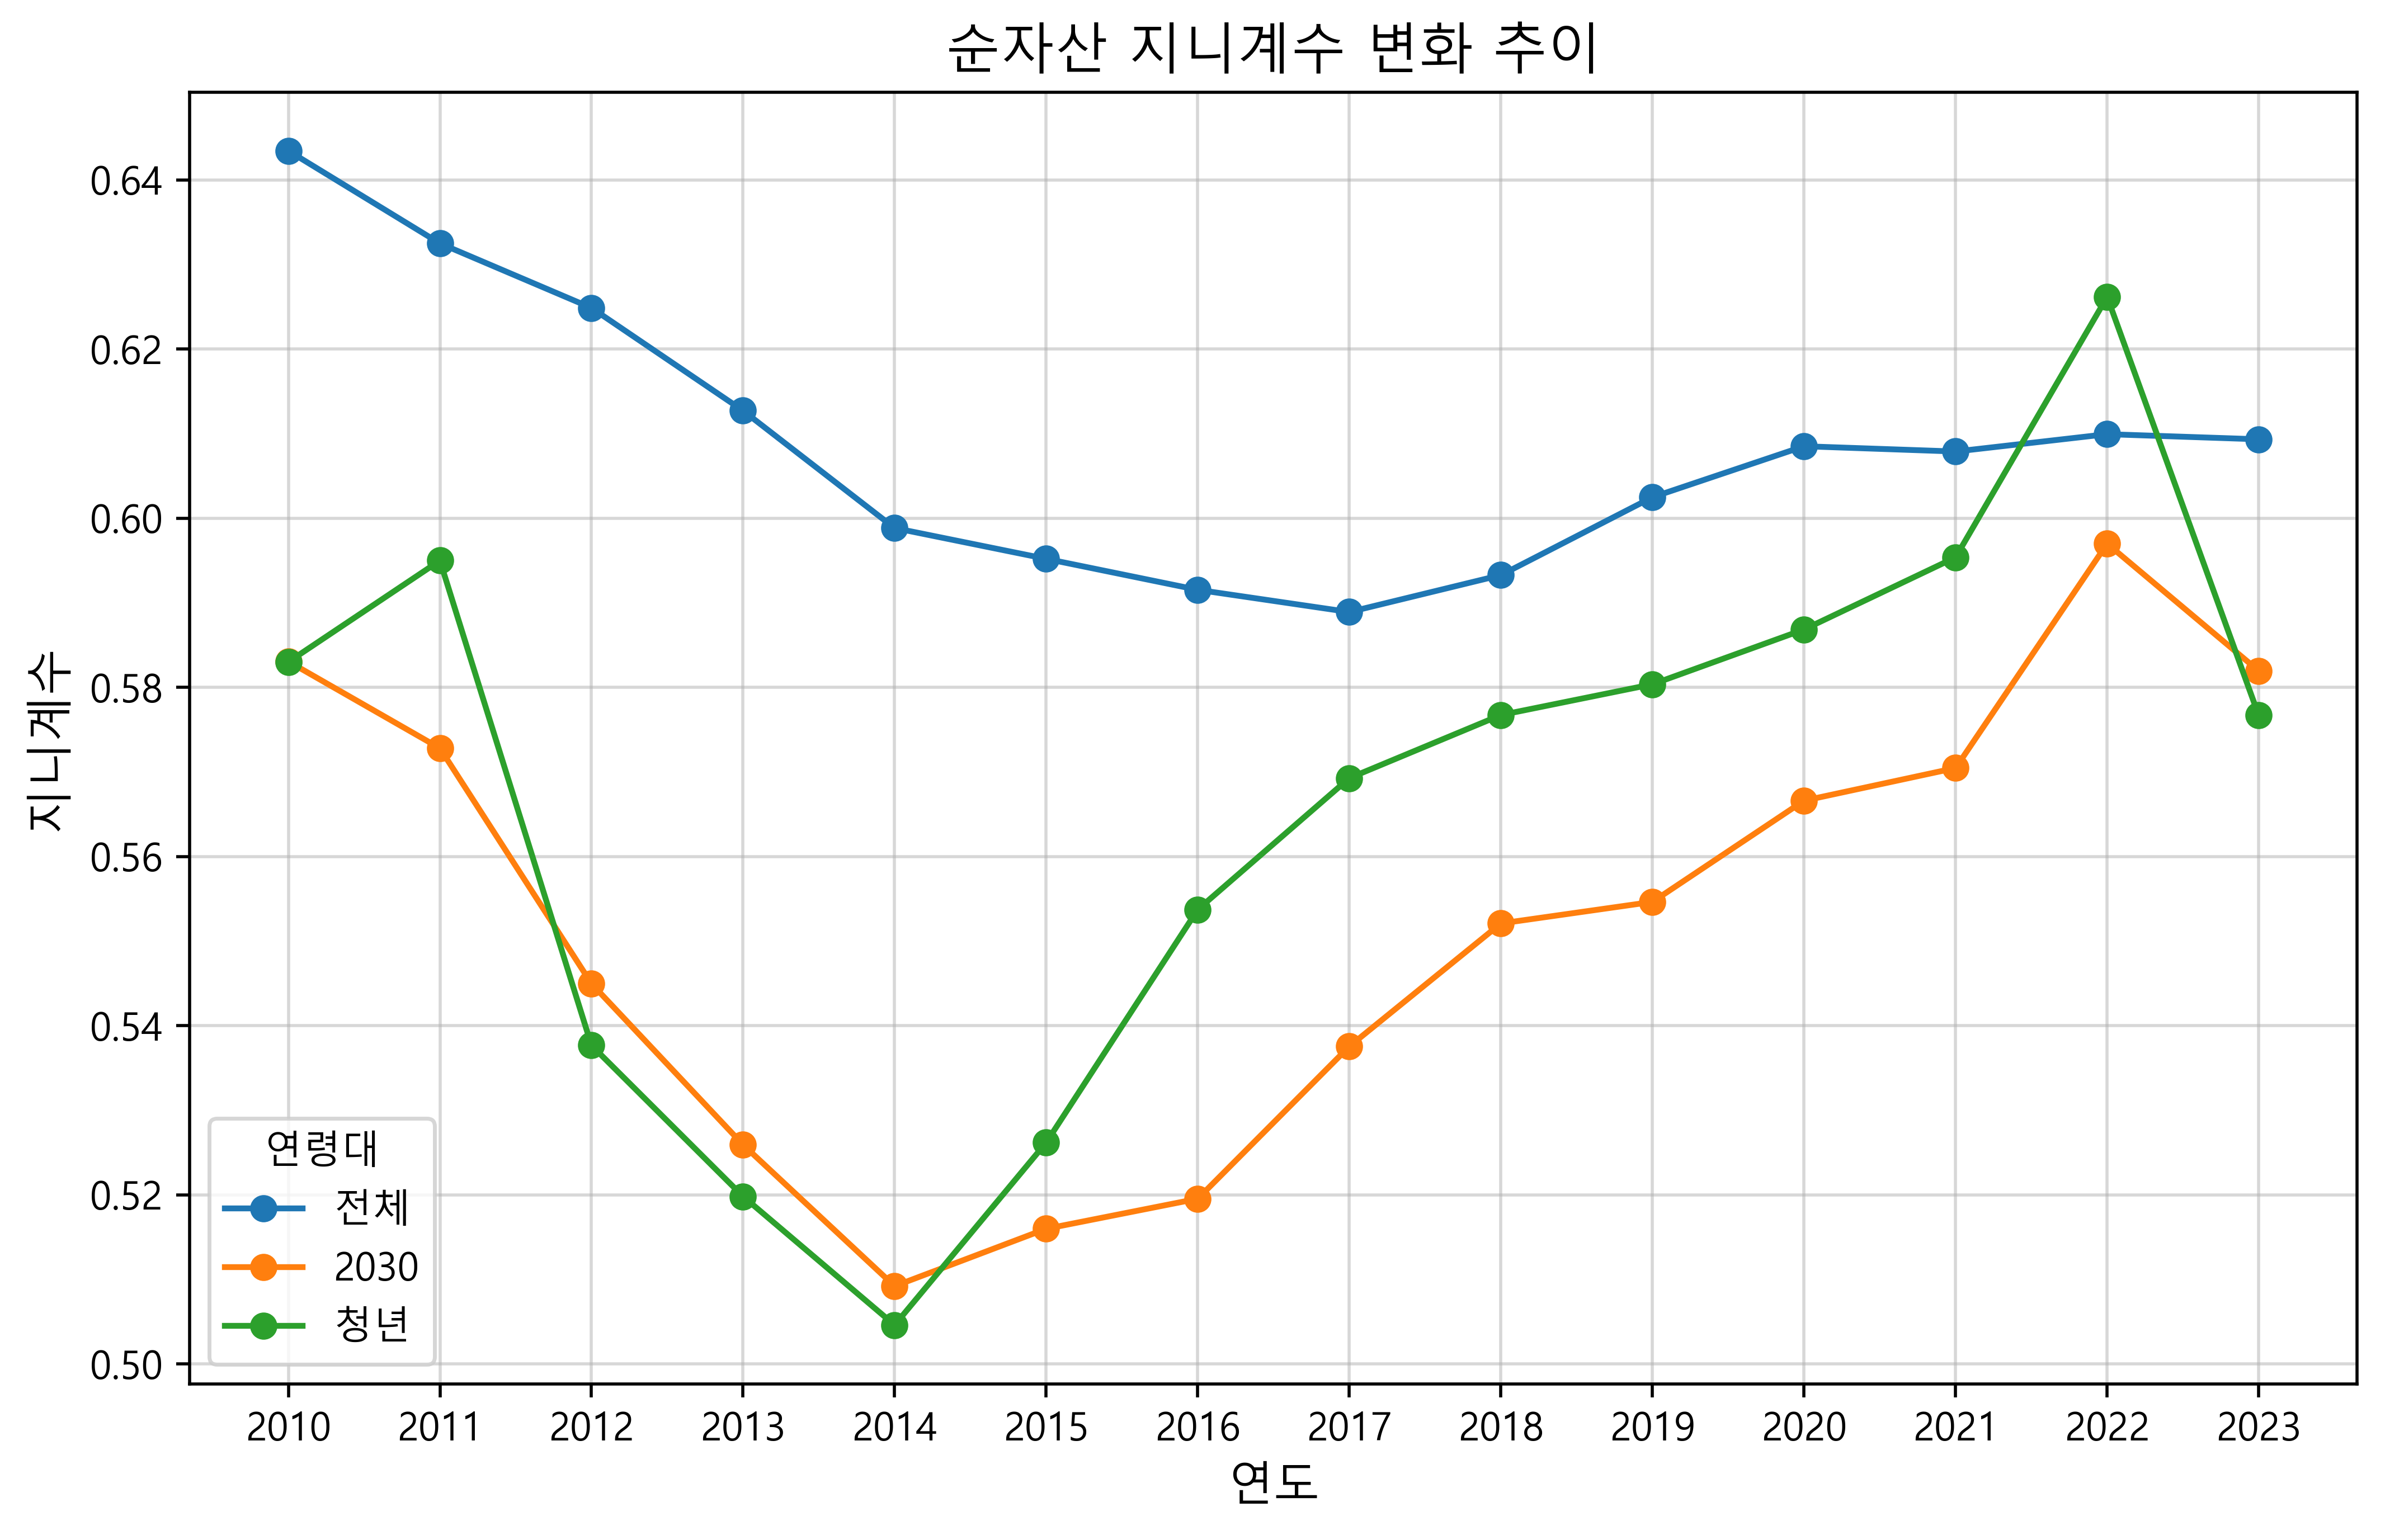

In [11]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(10, 6), dpi=500)

# 각 연령대의 gini 값 변화 추이 그리기
for column in ['전체', '2030', '청년']:
    plt.plot(df_gini_age.index, df_gini_age[column], marker='o', label=column)

# 그래프 제목 및 축 레이블 설정
plt.title('순자산 지니계수 변화 추이', fontsize=14)
plt.xlabel('연도', fontsize=12)
plt.ylabel('지니계수', fontsize=12)

# 범례 추가
plt.legend(title='연령대', fontsize=10)

# 격자 추가
plt.grid(alpha=0.5)

# 그래프 표시
plt.show()

### 수도권

In [12]:
import pandas as pd

# 연도 지정
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', 
         '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# 결과를 저장할 딕셔너리 초기화
networth_dict = {}
age_dict = {}
metro_dict = {}
weight_dict = {}

# 각 연도별로 파일 읽기 및 데이터 추출
for year in years:
    # 해당 연도에 대한 df 지정
    data = globals()[f'df_{year}']

    # '수도권여부' 필터링
    data = data[data['수도권여부'] == 'G1']
    
    # 순자산, 가구주_만연령, 가중값 추출 및 저장
    networth_dict[f'networth_{year}'] = data['순자산'] / 100 # 백만 원
    age_dict[f'age_{year}'] = data['가구주_만연령']
    weight_dict[f'weight_{year}'] = data['가중값']

In [13]:
# 연령대 정의
age_ranges = {'전체': (0, 200), '2030': (0, 39), '청년': (0, 34)}

# df_stats_age 초기화 (패널 데이터 형식)
index = pd.MultiIndex.from_product([years, age_ranges.keys()], 
                                   names=['year', 'age_range'])
df_stats_age = pd.DataFrame(index=index, columns=['mean', 'std', 'gini'])

# 각 연도 및 연령대별로 계산
for year in years:
    x1 = networth_dict[f'networth_{year}']
    x2 = age_dict[f'age_{year}']
    weight = weight_dict[f'weight_{year}']
    w = weight / weight.sum()
    
    for age_range, (age_min, age_max) in age_ranges.items():
        mask = (x2 >= age_min) & (x2 <= age_max)
        x1_filtered = x1[mask]
        w_filtered = w[mask]
        
        mean = weighted_mean(x1_filtered, w_filtered)
        std = weighted_std(x1_filtered, w_filtered)
        gini = weighted_gini(x1_filtered, w_filtered)
        
        df_stats_age.loc[(year, age_range), 'mean'] = mean
        df_stats_age.loc[(year, age_range), 'std'] = std
        df_stats_age.loc[(year, age_range), 'gini'] = gini

print("연도/연령대별 순자산 통계량")
print(df_stats_age)

연도/연령대별 순자산 통계량
                      mean         std      gini
year age_range                                  
2010 전체         302.711086  623.746913  0.635216
     2030       169.498123  239.511169  0.565546
     청년          126.48754  165.543701  0.562404
2011 전체         307.084771  624.337234   0.63159
     2030       174.635315  249.621029  0.562346
     청년          131.30121  203.694577  0.569911
2012 전체         334.322052  611.643399   0.62332
     2030       185.674597  224.378269  0.542399
     청년         140.851637  167.888606  0.538609
2013 전체         321.896565  604.297946  0.621768
     2030       174.789673  222.811246  0.536793
     청년         127.804228  149.104467  0.535054
2014 전체         325.277248  587.625473  0.608757
     2030       179.708904  195.399058  0.515909
     청년         133.016036  150.954824  0.513993
2015 전체          331.10556  578.593131  0.610158
     2030       179.032455  193.735321  0.518392
     청년         138.708812  162.804498  0.527098
2016

In [14]:
# gini 값만 추출하여 재구조화
df_gini_age = df_stats_age['gini'].unstack(level='age_range')
df_gini_age = df_gini_age[['전체', '2030', '청년']]

print("연도/연령대별 순자산 지니계수")
print(df_gini_age)

연도/연령대별 순자산 지니계수
age_range        전체      2030        청년
year                                   
2010       0.635216  0.565546  0.562404
2011        0.63159  0.562346  0.569911
2012        0.62332  0.542399  0.538609
2013       0.621768  0.536793  0.535054
2014       0.608757  0.515909  0.513993
2015       0.610158  0.518392  0.527098
2016        0.60423  0.516311  0.548064
2017       0.599612  0.548012  0.582481
2018       0.600812   0.57194  0.597093
2019       0.613348  0.579182  0.591485
2020        0.61644  0.584007   0.58034
2021       0.610671  0.578773  0.602863
2022       0.607483  0.601217  0.644482
2023       0.611289  0.583279   0.57084


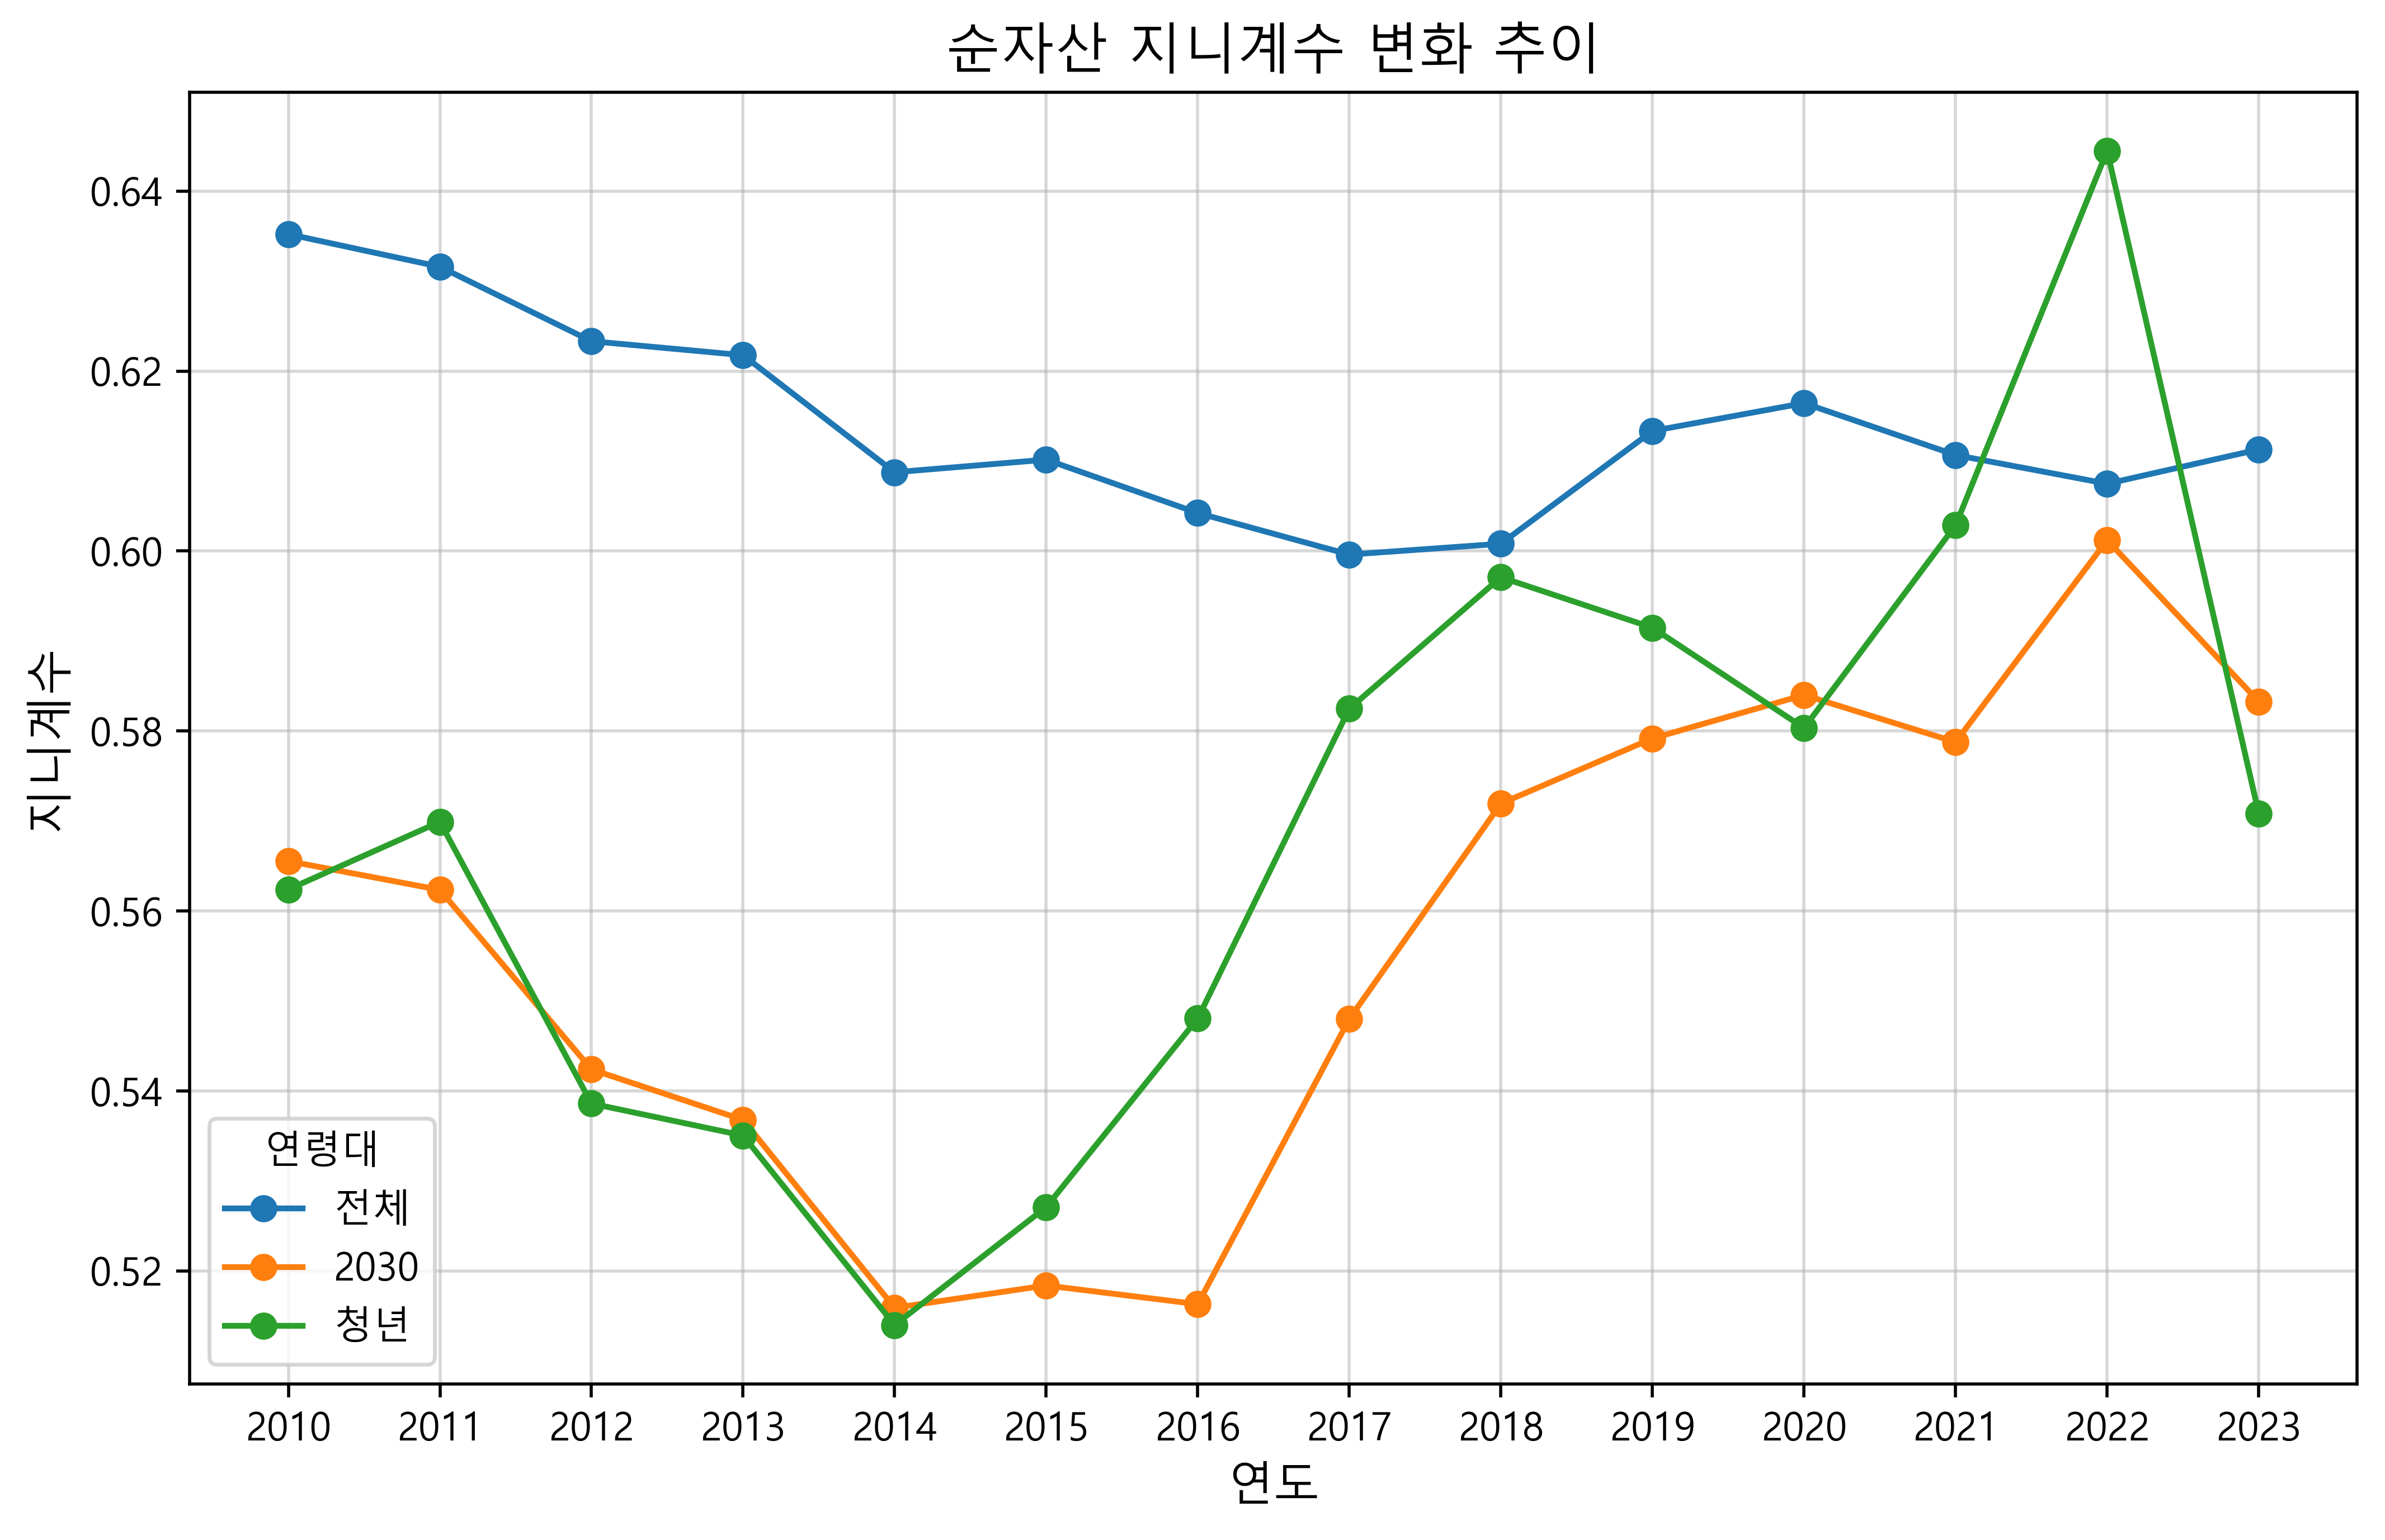

In [15]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(10, 6), dpi=500)

# 각 연령대의 gini 값 변화 추이 그리기
for column in ['전체', '2030', '청년']:
    plt.plot(df_gini_age.index, df_gini_age[column], marker='o', label=column)

# 그래프 제목 및 축 레이블 설정
plt.title('순자산 지니계수 변화 추이', fontsize=14)
plt.xlabel('연도', fontsize=12)
plt.ylabel('지니계수', fontsize=12)

# 범례 추가
plt.legend(title='연령대', fontsize=10)

# 격자 추가
plt.grid(alpha=0.5)

# 그래프 표시
plt.show()

### 해석

2030세대, 특히 청년층의 순자산 지니계수가 2015년부터 가파르게 높아진 데는 주택가격(특히 수도권) 급등과 부의 대물림이 크게 늘어난 것이 크게 작용한 것으로 판단된다.

![수도권 주택가격](https://raw.githubusercontent.com/pilsunchoi/images3/main/3-8.png)

- 데이터 출처: <a href="https://kremap.krihs.re.kr/grid/grid_global2">국토연구원 부동산시장정책연구센터</a>

## 4 가구소득

In [16]:
import pandas as pd

# 연도 지정
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', 
         '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# 결과를 저장할 딕셔너리 초기화
income_dict = {}
age_dict = {}
weight_dict = {}

# 각 연도별로 파일 읽기 및 데이터 추출
for year in years:
    # 해당 연도에 대한 df 지정
    data = globals()[f'df_{year}']
    
    # 가구주_만연령, 가중값 추출 및 저장
    age_dict[f'age_{year}'] = data['가구주_만연령']
    weight_dict[f'weight_{year}'] = data['가중값']
    
    # 연도별로 다른 소득 컬럼 처리
    if year in ['2010', '2011']:
        income_column = '조사_경상소득'
    elif year in ['2012', '2013', '2014', '2015', '2016']:
        income_column = '경상소득(조사)'
    else:  # 2017년부터 2023년까지
        income_column = '경상소득(보완)'
    
    # 통계당국 처분가능소득 계산
    x = data[income_column]
    income_dict[f'income_{year}'] = x / 100 # 백만 원

In [17]:
# 연령대 정의
age_ranges = {'전체': (0, 200), '2030': (0, 39), '청년': (0, 34)}

# df_stats_age 초기화 (패널 데이터 형식)
index = pd.MultiIndex.from_product([years, age_ranges.keys()], 
                                   names=['year', 'age_range'])
df_stats_age = pd.DataFrame(index=index, columns=['mean', 'std', 'gini'])

# 각 연도 및 연령대별로 계산
for year in years:
    x1 = income_dict[f'income_{year}']
    x2 = age_dict[f'age_{year}']
    weight = weight_dict[f'weight_{year}']
    w = weight / weight.sum()
    
    for age_range, (age_min, age_max) in age_ranges.items():
        mask = (x2 >= age_min) & (x2 <= age_max)
        x1_filtered = x1[mask]
        w_filtered = w[mask]
        
        mean = weighted_mean(x1_filtered, w_filtered)
        std = weighted_std(x1_filtered, w_filtered)
        gini = weighted_gini(x1_filtered, w_filtered)
        
        df_stats_age.loc[(year, age_range), 'mean'] = mean
        df_stats_age.loc[(year, age_range), 'std'] = std
        df_stats_age.loc[(year, age_range), 'gini'] = gini

print("연도/연령대별 소득 통계량")
print(df_stats_age)

연도/연령대별 소득 통계량
                     mean        std      gini
year age_range                                
2010 전체         37.729263  35.666476  0.432597
     2030       38.748152  31.054725  0.335447
     청년         33.823743  21.832978  0.317909
2011 전체          40.11769  45.266612  0.453477
     2030       40.258164   31.42681  0.334864
     청년            36.697  25.597783  0.329819
2012 전체         42.334004  45.183263   0.43791
     2030       43.149169  29.554049  0.326589
     청년         38.521289  23.552304  0.313823
2013 전체         44.785288  45.515289  0.429451
     2030       45.246769  30.844498  0.324586
     청년         39.745768  24.391265  0.312205
2014 전체          46.58477  44.492048  0.425873
     2030       47.861919  33.497429  0.317754
     청년          42.29219  31.345191  0.303075
2015 전체         47.695587  42.590169  0.422841
     2030       48.702121  30.331436  0.309765
     청년         43.780218  25.842378  0.305185
2016 전체         48.818554   43.37079  0.42131

In [18]:
# gini 값만 추출하여 재구조화
df_gini_age = df_stats_age['gini'].unstack(level='age_range')
df_gini_age = df_gini_age[['전체', '2030', '청년']]

print("연도/연령대별 소득 지니계수")
print(df_gini_age)

연도/연령대별 소득 지니계수
age_range        전체      2030        청년
year                                   
2010       0.432597  0.335447  0.317909
2011       0.453477  0.334864  0.329819
2012        0.43791  0.326589  0.313823
2013       0.429451  0.324586  0.312205
2014       0.425873  0.317754  0.303075
2015       0.422841  0.309765  0.305185
2016       0.421318  0.308492    0.3112
2017       0.436399  0.347723  0.354427
2018       0.437351   0.33884   0.34056
2019       0.434313  0.331942  0.327485
2020       0.431978    0.3436  0.333909
2021       0.423237  0.352425  0.342976
2022       0.426013  0.368121  0.359731
2023       0.420402  0.358372  0.343803


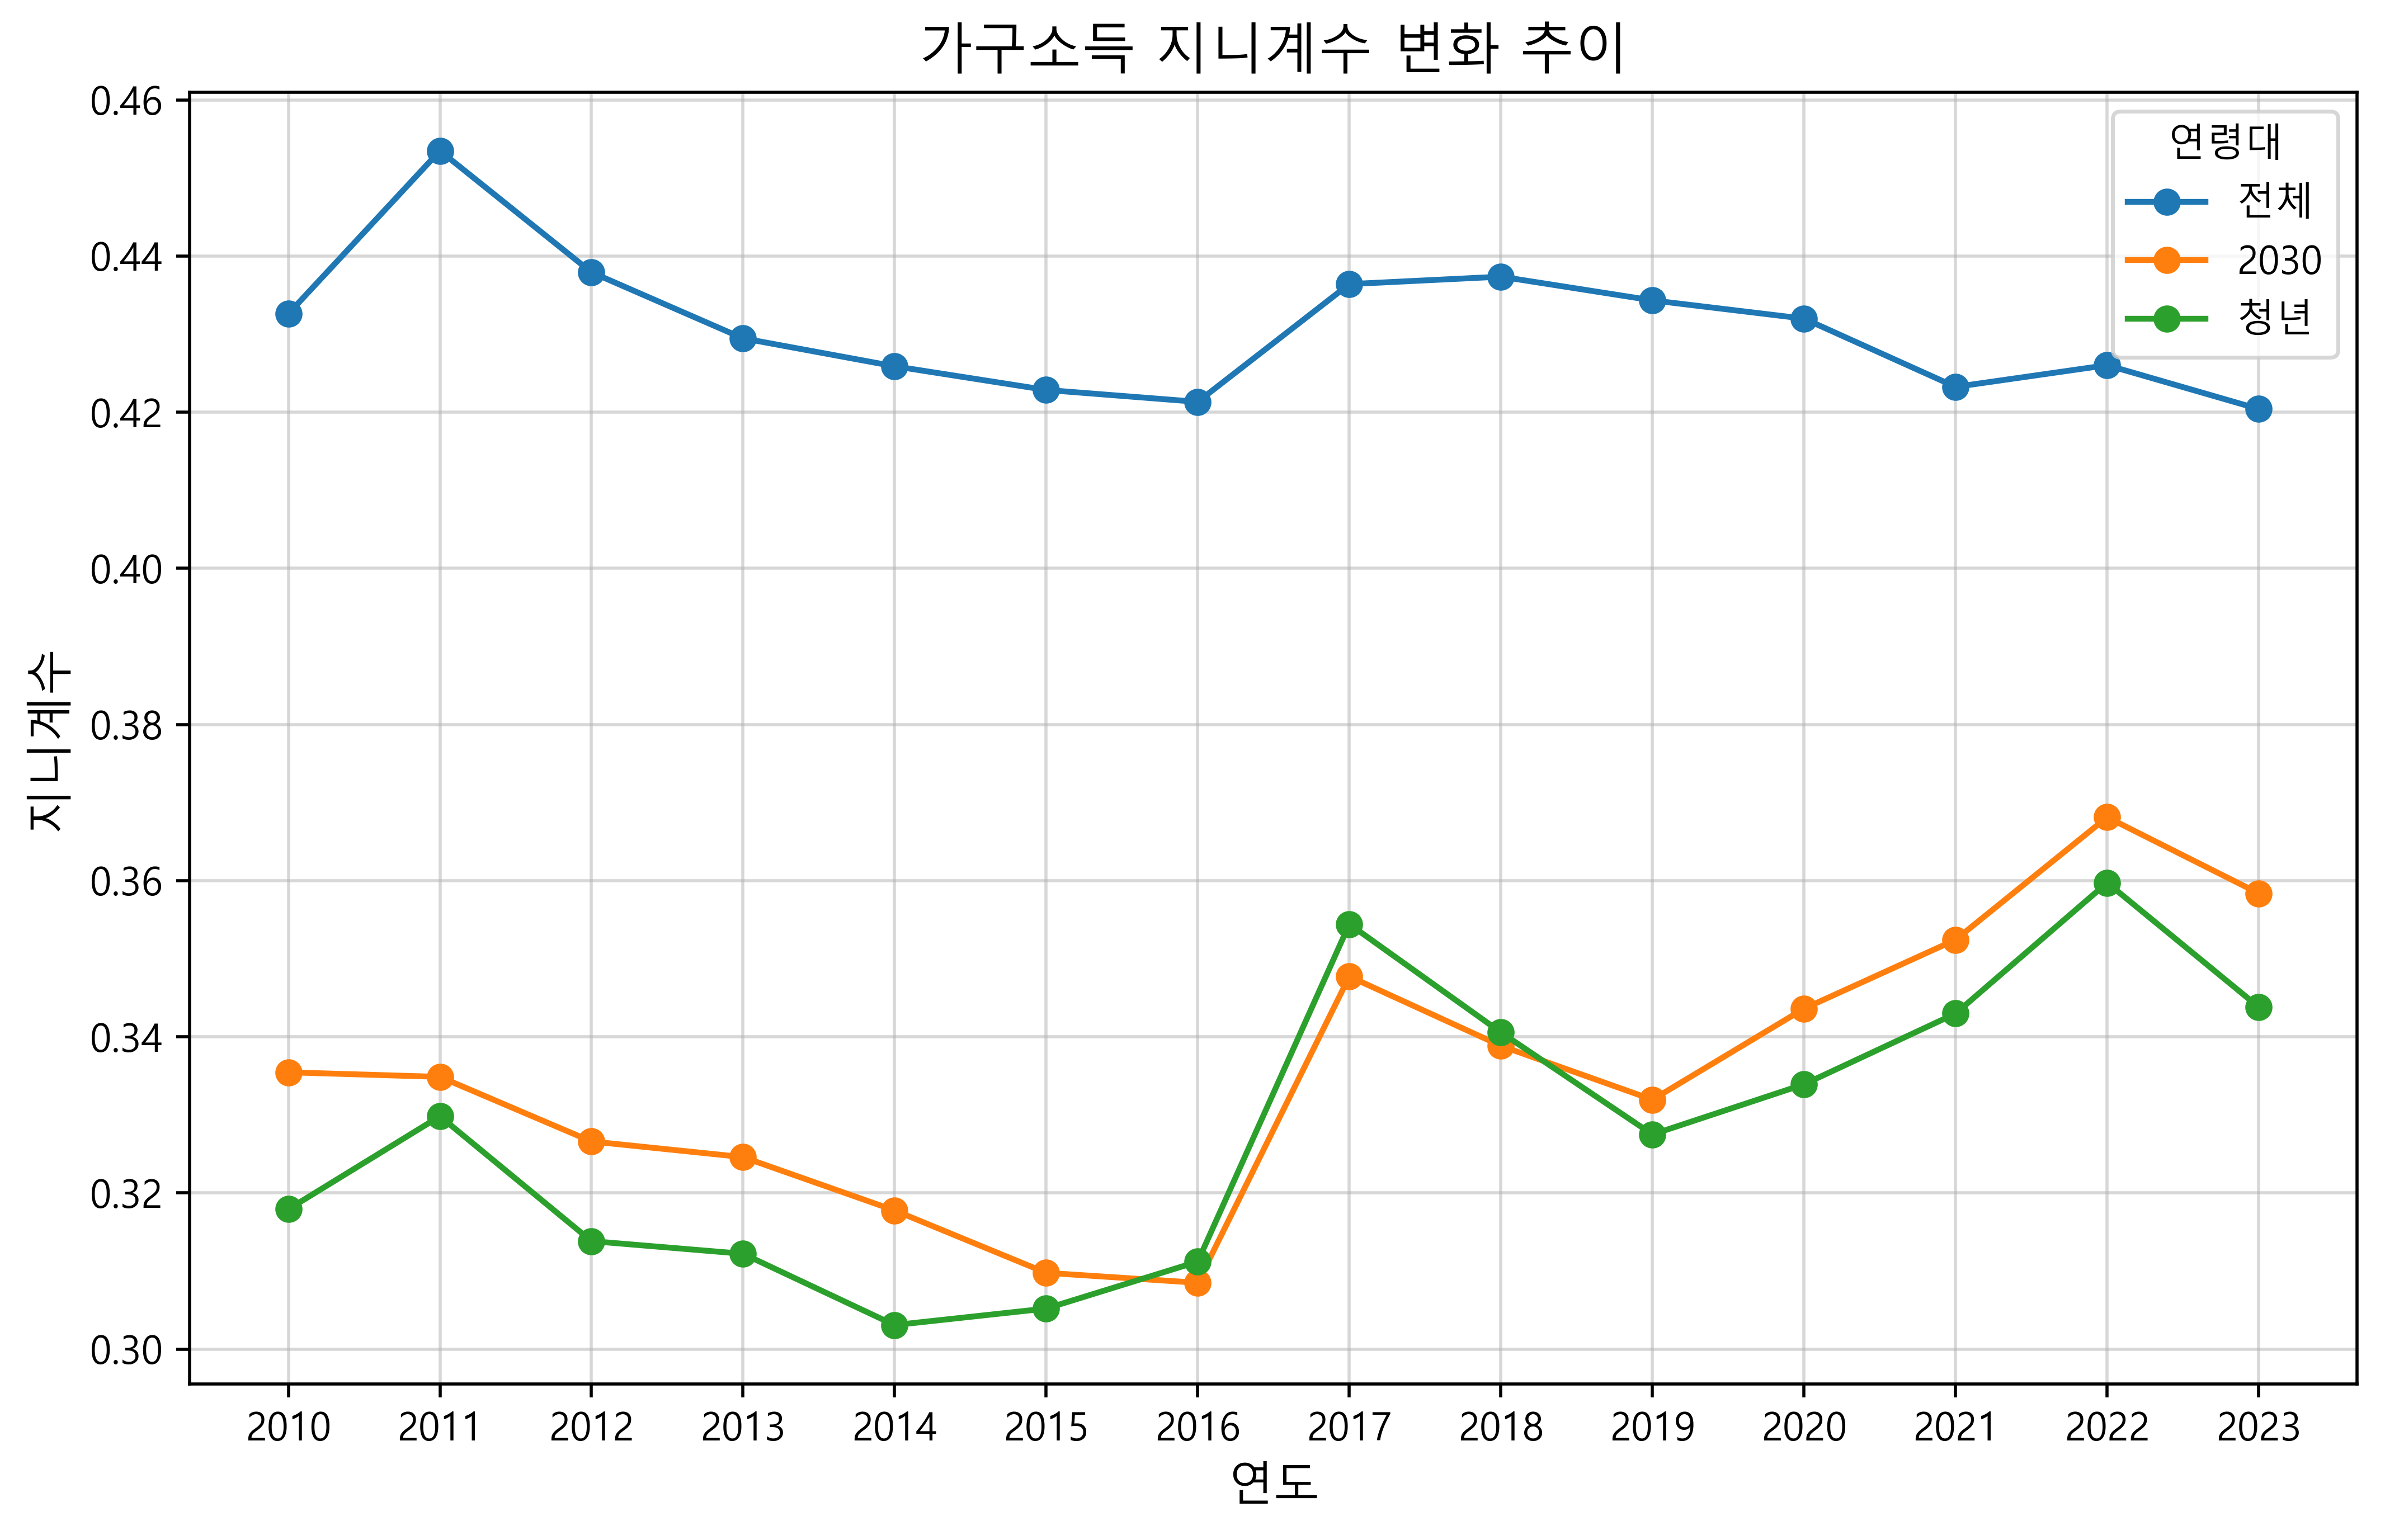

In [19]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(10, 6), dpi=500)

# 각 연령대의 gini 값 변화 추이 그리기
for column in ['전체', '2030', '청년']:
    plt.plot(df_gini_age.index, df_gini_age[column], marker='o', label=column)

# 그래프 제목 및 축 레이블 설정
plt.title('가구소득 지니계수 변화 추이', fontsize=14)
plt.xlabel('연도', fontsize=12)
plt.ylabel('지니계수', fontsize=12)

# 범례 추가
plt.legend(title='연령대', fontsize=10)

# 격자 추가
plt.grid(alpha=0.5)

# 그래프 표시
plt.show()

## 5 처분가능소득

In [20]:
import pandas as pd

# 연도 지정
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', 
         '2017', '2018', '2019', '2020', '2021', '2022', '2023']

# 결과를 저장할 딕셔너리 초기화
income_dict = {}
age_dict = {}
weight_dict = {}

# 각 연도별로 파일 읽기 및 데이터 추출
for year in years:
    # 해당 연도에 대한 df 지정
    data = globals()[f'df_{year}']
    
    # 가구주_만연령, 가중값 추출 및 저장
    age_dict[f'age_{year}'] = data['가구주_만연령']
    weight_dict[f'weight_{year}'] = data['가중값']
    
    # 해당 연도의 '처분가능소득' 변수명 설정
    if year in ['2010', '2011']:
        income_column = '조사_처분가능소득'
    elif year in ['2012', '2013', '2014', '2015', '2016']:
        income_column = '처분가능소득(조사)[경상소득-비소비지출]'
    else:
        income_column = '처분가능소득(보완)[경상소득(보완)-비소비지출(보완)]'

    # 해당 연도의 '연간지급이자' 변수명 설정
    if year in ['2010', '2011']:
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    elif year in ['2012']:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    elif year in ['2013', '2014', '2015']:
        interest_payment = '조사_지출_비소비지출_연간지급이자'
    else:
        interest_payment = '지출_비소비지출_연간지급이자(조사)'
    
    # 통계당국 처분가능소득 계산
    x = data[income_column] + data[interest_payment]
    income_dict[f'income_{year}'] = x / 100 # 백만 원

In [21]:
# 연령대 정의
age_ranges = {'전체': (0, 200), '2030': (0, 39), '청년': (0, 34)}

# df_stats_age 초기화 (패널 데이터 형식)
index = pd.MultiIndex.from_product([years, age_ranges.keys()], 
                                   names=['year', 'age_range'])
df_stats_age = pd.DataFrame(index=index, columns=['mean', 'std', 'gini'])

# 각 연도 및 연령대별로 계산
for year in years:
    x1 = income_dict[f'income_{year}']
    x2 = age_dict[f'age_{year}']
    weight = weight_dict[f'weight_{year}']
    w = weight / weight.sum()
    
    for age_range, (age_min, age_max) in age_ranges.items():
        mask = (x2 >= age_min) & (x2 <= age_max)
        x1_filtered = x1[mask]
        w_filtered = w[mask]
        
        mean = weighted_mean(x1_filtered, w_filtered)
        std = weighted_std(x1_filtered, w_filtered)
        gini = weighted_gini(x1_filtered, w_filtered)
        
        df_stats_age.loc[(year, age_range), 'mean'] = mean
        df_stats_age.loc[(year, age_range), 'std'] = std
        df_stats_age.loc[(year, age_range), 'gini'] = gini

print("연도/연령대별 소득 통계량")
print(df_stats_age)

연도/연령대별 소득 통계량
                     mean        std      gini
year age_range                                
2010 전체         32.351046  31.178492  0.433686
     2030       32.968694  27.657438  0.341384
     청년         28.775827  18.696268  0.322295
2011 전체         34.858431  41.116273  0.453805
     2030       34.957992  28.417748  0.336809
     청년         32.010601  22.716567   0.33152
2012 전체         36.570673  38.753776   0.42765
     2030       37.135557  25.170997  0.318999
     청년         33.322171   19.93728   0.30693
2013 전체         38.427659    39.5943  0.422294
     2030       38.815289  26.470464  0.319648
     청년         34.350716  20.941127  0.309366
2014 전체          40.02168   38.35484  0.417371
     2030       41.054485  29.236157   0.31345
     청년          36.60937  28.548871  0.301676
2015 전체         40.986633  35.718795  0.413415
     2030       41.634252  24.853045  0.302998
     청년         37.719369  21.504912  0.298726
2016 전체         41.983472  36.744472  0.41117

In [22]:
# gini 값만 추출하여 재구조화
df_gini_age = df_stats_age['gini'].unstack(level='age_range')
df_gini_age = df_gini_age[['전체', '2030', '청년']]

print("연도/연령대별 소득 지니계수")
print(df_gini_age)

연도/연령대별 소득 지니계수
age_range        전체      2030        청년
year                                   
2010       0.433686  0.341384  0.322295
2011       0.453805  0.336809   0.33152
2012        0.42765  0.318999   0.30693
2013       0.422294  0.319648  0.309366
2014       0.417371   0.31345  0.301676
2015       0.413415  0.302998  0.298726
2016       0.411177  0.300147  0.304615
2017       0.425839  0.339751   0.35138
2018       0.425811  0.336298  0.337152
2019       0.419805  0.321993  0.322197
2020       0.416496  0.328773  0.327935
2021       0.406417  0.337595  0.332454
2022       0.408877   0.35563  0.353511
2023       0.402404  0.344645  0.336099


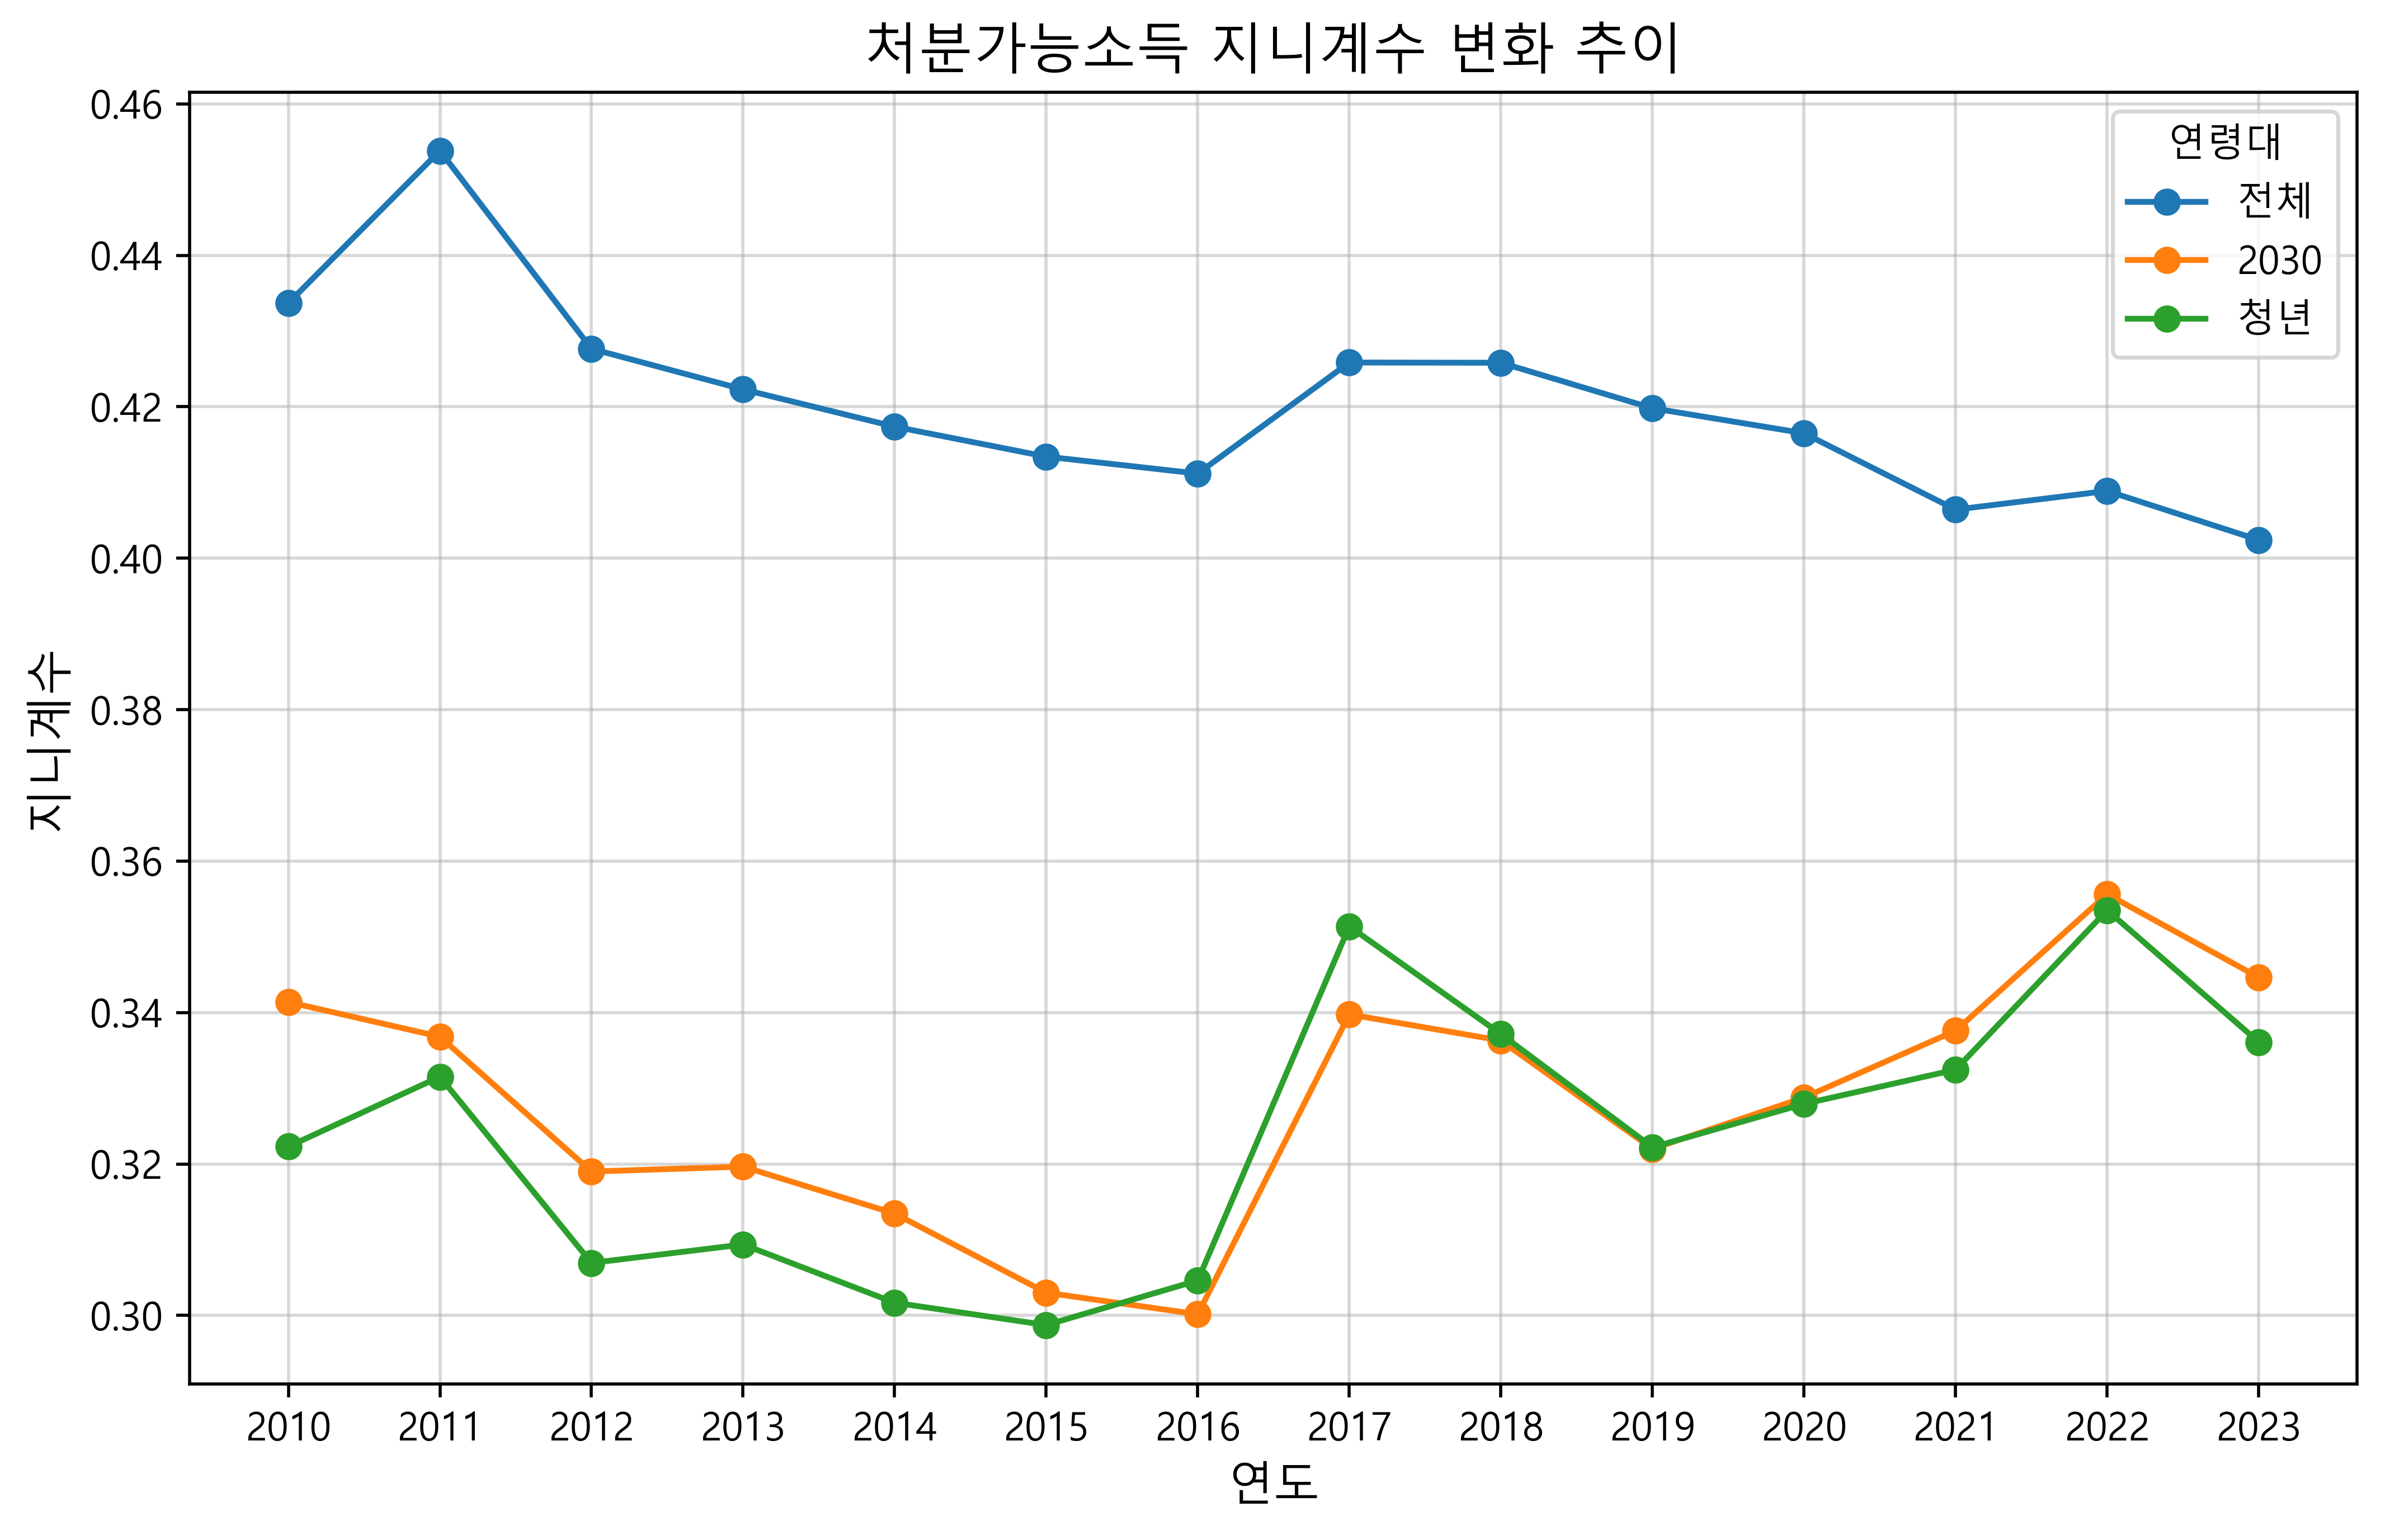

In [23]:
import matplotlib.pyplot as plt

# 그래프 크기 설정
plt.figure(figsize=(10, 6), dpi=500)

# 각 연령대의 gini 값 변화 추이 그리기
for column in ['전체', '2030', '청년']:
    plt.plot(df_gini_age.index, df_gini_age[column], marker='o', label=column)

# 그래프 제목 및 축 레이블 설정
plt.title('처분가능소득 지니계수 변화 추이', fontsize=14)
plt.xlabel('연도', fontsize=12)
plt.ylabel('지니계수', fontsize=12)

# 범례 추가
plt.legend(title='연령대', fontsize=10)

# 격자 추가
plt.grid(alpha=0.5)

# 그래프 표시
plt.show()